In [2]:
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt
from IPython import get_ipython
from numpy.linalg import svd
from util import nextplot, plot_xy
from sklearn.cluster import KMeans

%matplotlib notebook

# 1 Probabilistic PCA

## 1a) Toy data

In [3]:
# You do not need to modify this method.
def ppca_gen(N=10000, D=2, L=2, sigma2=0.5, mu=None, lambda_=None, Q=None, seed=None):
    """Generate data from a given PPCA model.

    Unless specified otherwise, uses a fixed mean, fixed eigenvalues (variances along
    principal components), and a random orthogonal eigenvectors (principal components).

    """

    # determine model parameters (from arguments or default)
    if seed is not None:
        np.random.seed(seed)
    if mu is None:
        mu = np.arange(D) + 1.0
    if Q is None:
        Q = scipy.stats.ortho_group.rvs(D)
    if lambda_ is None:
        lambda_ = np.arange(D, 0, -1) * 2

    # weight matrix is determined from first L eigenvectors and eigenvalues of
    # covariance matrix
    Q_L = Q[:, :L]
    lambda_L = lambda_[:L]
    W = Q_L * np.sqrt(lambda_L)  # scales columns

    # generate data
    Z = np.random.randn(N, L)  # latent variables
    Eps = np.random.randn(N, D) * np.sqrt(sigma2)  # noise
    X = Z @ W.transpose() + mu + Eps  # data points

    # all done
    return dict(
        N=N, D=D, L=L, X=X, Z=Z, mu=mu, Q_L=Q_L, lambda_L=lambda_L, W=W, Eps=Eps
    )

In [5]:
# You do not need to modify this method.
def ppca_plot_2d(data, X="X", mu="mu", W="W", alpha=0.05, axis=None, **kwargs):
    """Plot 2D PPCA data along with its weight vectors."""
    if not axis:
        nextplot()
        axis = plt.gca()
    X = data[X] if isinstance(X, str) else X
    plot_xy(X[:, 0], X[:, 1], alpha=alpha, axis=axis, **kwargs)

    # additional plot elements: mean and components
    if mu is not None:
        mu = data[mu] if isinstance(mu, str) else mu
        if W is not None:
            W = data[W] if isinstance(W, str) else W
            head_width = np.linalg.norm(W[:, 0]) / 10.0
            for j in range(W.shape[1]):
                axis.arrow(
                    mu[0],
                    mu[1],
                    W[0, j],
                    W[1, j],
                    length_includes_head=True,
                    head_width=head_width,
                )

<IPython.core.display.Javascript object>


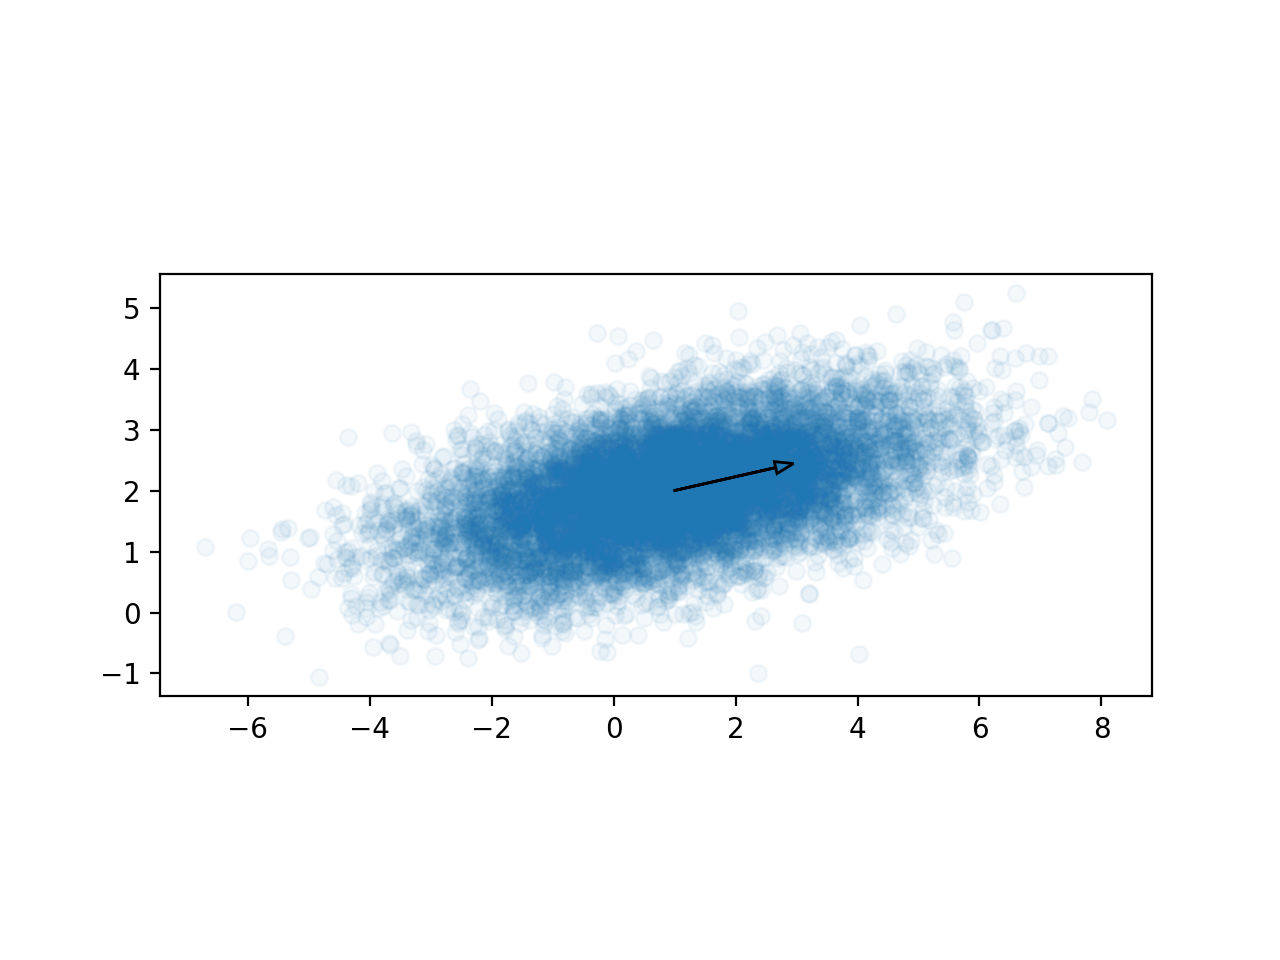

In [15]:
# Generate and plot a toy dataset
toy_ppca = ppca_gen(L=1, sigma2=0.5, seed=0)
ppca_plot_2d(toy_ppca)
#print(np.sum(toy_ppca["X"] ** 3))  # must be 253376.52003073416

In [ ]:
# Impact of noise
# YOUR CODE HERE

## 1b) Maximum Likelihood Estimation

In [98]:
def ppca_mle(X, L):
    """Computes the ML estimates of PPCA model parameters.

    Returns a dictionary with keys `mu`, `W`, and `sigma2` and the corresponding ML
    estimates as values.

    """
    N, D = X.shape

    # Compute the ML estimates of the PPCA model parameters: mu_mle, sigma2_mle (based
    # on mu_mle), and W_mle (based on mu_mle and sigma2_mle). In your code, only use
    # standard matrix/vector operations and svd(...).
    # YOUR CODE HERE
    X = X / np.linalg.norm(X)
    XtX = X.transpose() @ X
    U, s, Vt = svd(XtX)
#    W_mle = Vt.transpose()[0:L,:] @ (np.square(s) - )
    
    sigma2_mle = 1/(D-(L-1)) * np.sum(s[L-1:D])


 #   return dict(mu=mu_mle, W=W_mle, sigma2=sigma2_mle)
    return dict(sigma2=sigma2_mle)

In [99]:
# Test your solution. This should produce:
# {'mu': array([0.96499135, 1.99411338]),
#  'W': array([[-1.92216075], [-0.42851619]]),
#  'sigma2': 0.5021816994668619}
ppca_mle(toy_ppca["X"], 1)

{'sigma2': 0.49999999999999994}

In [94]:
# Test your solution. This should produce:
# {'mu': array([0.96499135, 1.99411338]),
#  'W': array([[-2.0428184 ,  0.15419681], [-0.45541495, -0.6916683 ]]),
#  'sigma2': 0.0}
ppca_mle(toy_ppca["X"], 2)

2
[0.2183124]


{'sigma2': 0.21831240483114323}

## 1c) Negative Log-Likelihood

In [ ]:
def ppca_nll(X, model):
    """Compute the negative log-likelihood for the given data.

    Model is a dictionary containing keys "mu", "sigma2" and "W" (as produced by
    `ppca_mle` above).

    """
    N, D = X.shape
    W = model["W"]
    
    C = W @ W.transpose() + sigma_2 * np.identity(len(sigma2))
    
    return -N/2*np.log(np.absolute(C)) - 1/2*np.sum()

In [ ]:
# Test your solution. This should produce: 32320.62982368089
ppca_nll(toy_ppca["X"], ppca_mle(toy_ppca["X"], 1))

## 1d) Discover the Secret!

In [ ]:
# Load the secret data
X = np.loadtxt("data/secret_ppca.csv", delimiter=",")

In [ ]:
# Determine a suitable choice of L using a scree plot.
# Your code here

In [ ]:
# Determine a suitable choice of L using validation data.
split = len(X) * 3 // 4
X_train = X[:split,]
X_valid = X[split:,]

In [ ]:
# YOUR CODE HERE

# 2 Gaussian Mixture Models

## 2a) Toy data

In [16]:
# You do not need to modify this function.
def gmm_gen(N, mu, pi, Sigma=None, seed=None):
    """Generate data from a given GMM model.

    `N` is the number of data points to generate. `mu` and `Sigma` are lists with `K`
    elements holding the mean and covariance matrix of each mixture component. `pi` is a
    `K`-dimensional probability vector of component sizes.

    If `Sigma` is unspecified, a default (random) choice is taken.
    """
    K = len(pi)
    D = len(mu[0])
    if seed is not None:
        np.random.seed(seed)
    if Sigma is None:
        Sigma = [
            Q.transpose() @ np.diag([(k + 1) ** 2, k + 1]) @ Q
            for k, Q in enumerate([scipy.stats.ortho_group.rvs(2) for k in range(K)])
        ]

    components = np.random.choice(range(K), p=pi, size=N)
    X = np.zeros([N, D])
    for k in range(K):
        indexes = components == k
        N_k = np.sum(indexes.astype(np.int))
        if N_k == 0:
            continue

        dist = scipy.stats.multivariate_normal(mean=mu[k], cov=Sigma[k])
        X[indexes, :] = dist.rvs(size=N_k)

    return dict(X=X, components=components, mu=mu, Sigma=Sigma, pi=pi)

-4217163.292239752


/tmp/ipykernel_377/3213974799.py:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  N_k = np.sum(indexes.astype(np.int))


<IPython.core.display.Javascript object>


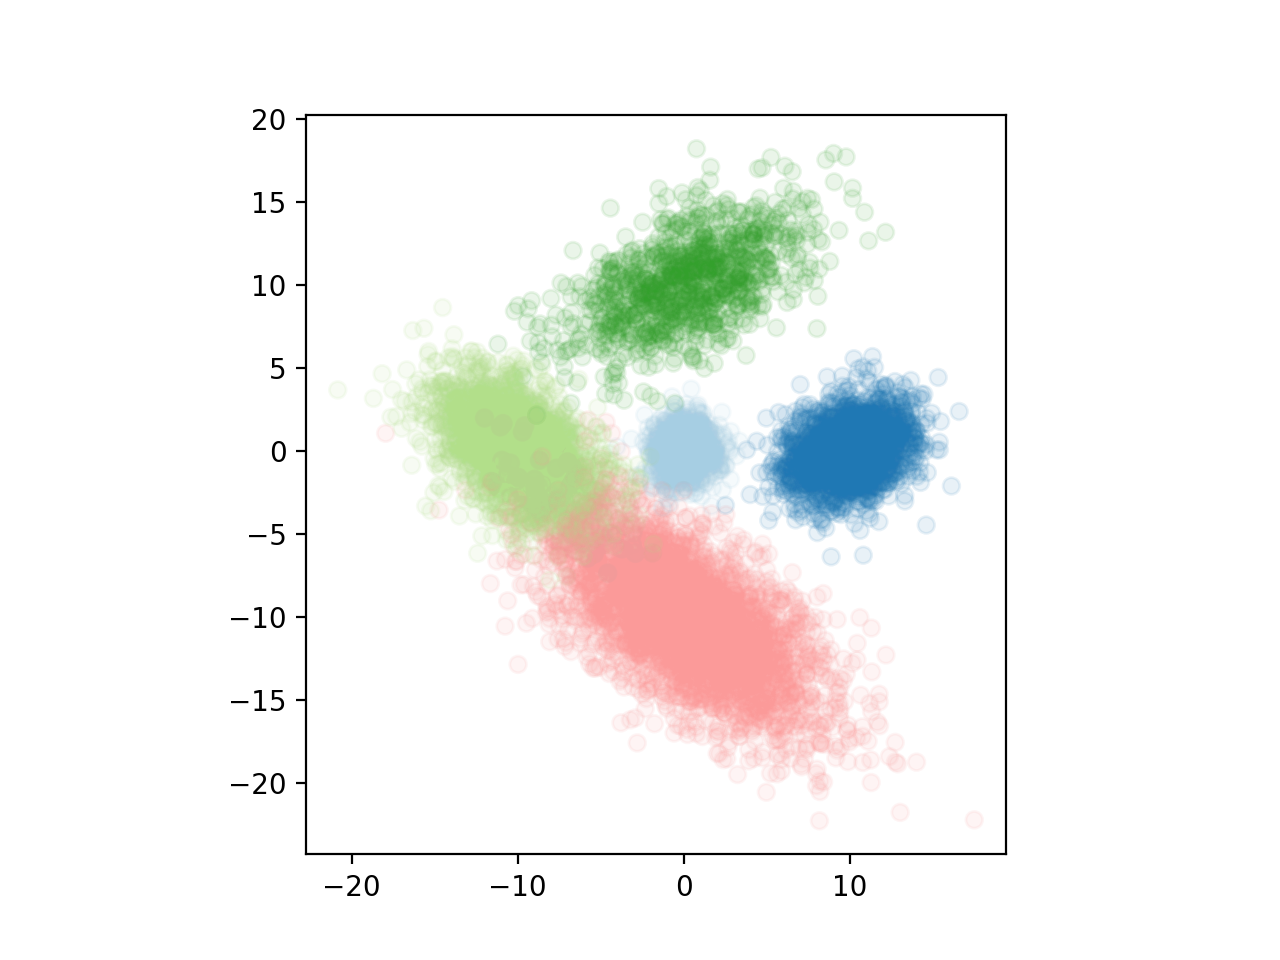

In [17]:
# Generate a toy dataset and plot it.
toy_gmm = gmm_gen(
    10000,
    [
        np.array([0, 0]),
        np.array([10, 0]),
        np.array([-10, 0]),
        np.array([0, 10]),
        np.array([0, -10]),
    ],
    np.array([0.1, 0.2, 0.25, 0.1, 0.35]),
    seed=4,
)

print(np.sum(toy_gmm["X"] ** 3))  # must be -4217163.292239752

plot_xy(toy_gmm["X"][:, 0], toy_gmm["X"][:, 1], toy_gmm["components"], alpha=0.1)

## 2b) K-Means

<IPython.core.display.Javascript object>


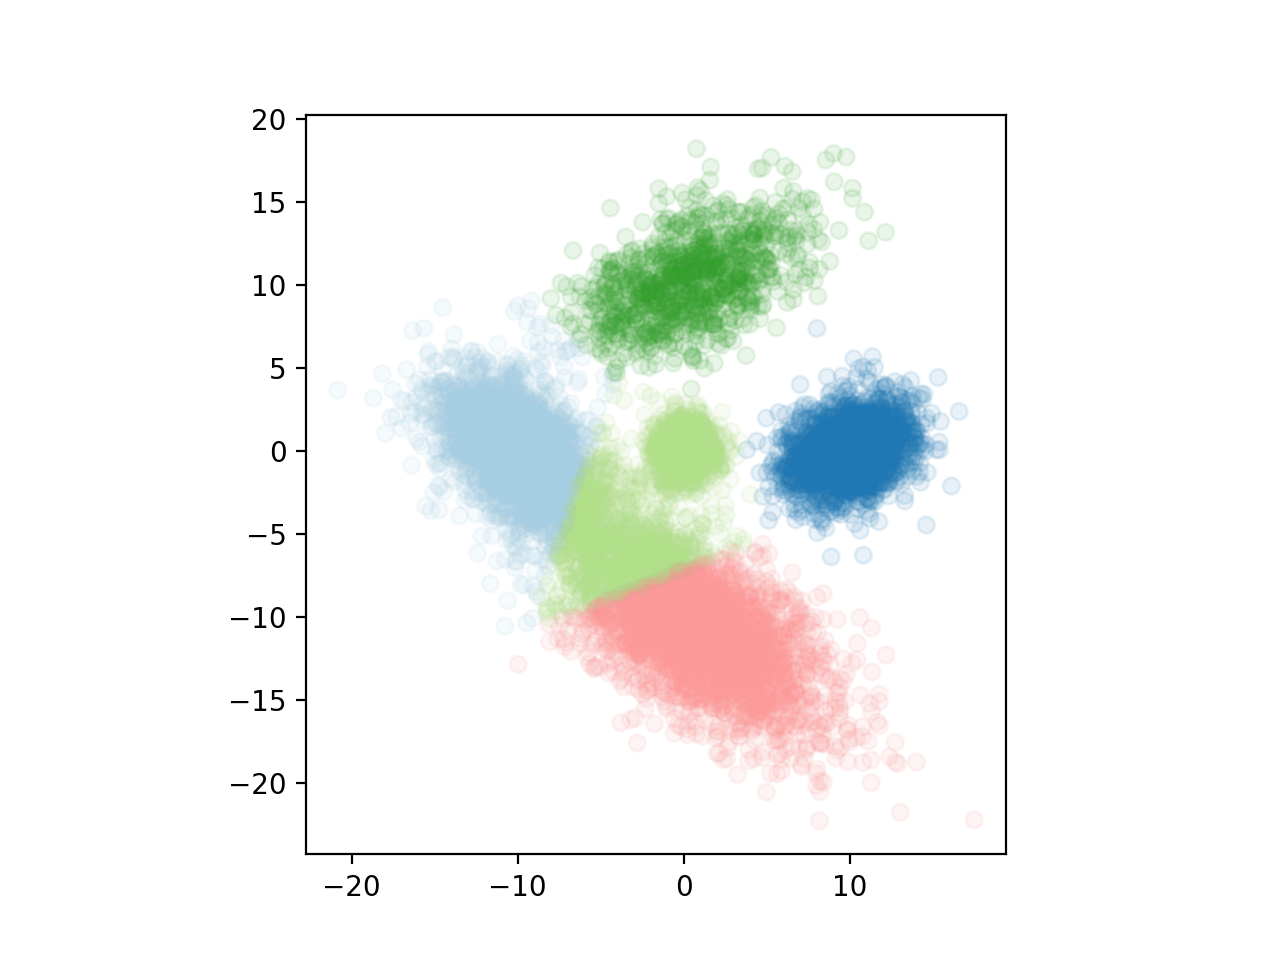

In [18]:
# Fit 5 clusters using k-means.
kmeans = KMeans(5).fit(toy_gmm["X"])
plot_xy(toy_gmm["X"][:, 0], toy_gmm["X"][:, 1], kmeans.labels_, alpha=0.1)

## 2c) Fit a GMM

In [ ]:
def gmm_e(X, model, return_F=False):
    """Perform the E step of EM for a GMM (MLE estimate).

    `model` is a dictionary holding model parameters (keys `mu`, `Sigma`, and `pi`
    defined as in `gmm_gen`).

    Returns a NxK matrix of cluster membership probabilities. If `return_F` is true,
    also returns an NxK matrix holding the density of each data point (row) for each
    component (column).

    """
    mu, Sigma, pi = model["mu"], model["Sigma"], model["pi"]
    N, D = X.shape
    K = len(pi)

    # YOUR CODE HERE

    # all done
    if return_F:
        return W, F
    else:
        return W

In [ ]:
# Test your solution. This should produce:
# (array([[1.00000000e+000, 8.27699923e-031, 2.34110986e-067,
#          4.10467740e-110, 3.93734426e-160],
#         [9.99999954e-001, 4.61690063e-008, 5.65425711e-019,
#          3.33201883e-033, 8.33882728e-052],
#         [1.00000000e+000, 1.86295657e-011, 1.28430390e-026,
#          5.94329943e-046, 1.62944956e-070]]),
#  array([[1.02589878e-027, 3.39654536e-058, 1.60116117e-094,
#          2.10549177e-137, 1.34643889e-187],
#         [7.37197125e-008, 1.36142641e-015, 2.77886819e-026,
#          1.22817741e-040, 2.04911993e-059],
#         [2.13229824e-010, 1.58895161e-021, 1.82567931e-036,
#          6.33644347e-056, 1.15815748e-080]]))
dummy_model = dict(
    mu=[np.array([k, k + 1]) for k in range(5)],
    Sigma=[np.array([[3, 1], [1, 2]]) / (k + 1) for k in range(5)],
    pi=np.array([0.1, 0.25, 0.15, 0.2, 0.3]),
)
gmm_e(toy_gmm["X"][:3,], dummy_model, return_F=True)

In [ ]:
def gmm_m(X, W):
    """Perform the M step of EM for a GMM (MLE estimate).

    `W` is the NxK cluster membership matrix computed in the E step. Returns a new model
    (dictionary with keys `mu`, `Sigma`, and `pi` defined as in `gmm_gen`).

    """
    N, D = X.shape
    K = W.shape[1]

    # YOUR CODE HERE

    return dict(mu=mu, Sigma=Sigma, pi=pi)

In [ ]:
# Test your solution. This should produce:
# {'mu': [array([-6.31351787, -3.07275642]),
#   array([-8.76676837, -2.34516689]),
#   array([-2.08994533, -8.92768065])],
#  'Sigma': [array([[ 16.51718982, -22.89694189],
#          [-22.89694189,  31.74086835]]), array([[ 13.62163617, -13.69361772],
#          [-13.69361772,  16.07669971]]), array([[ 18.4992526 , -25.64457491],
#          [-25.64457491,  35.54977255]])],
#  'pi': array([0.13333333, 0.53333333, 0.33333333])}
gmm_m(toy_gmm["X"][:3,], np.array([[0.1, 0.2, 0.7], [0.3, 0.4, 0.3], [0.0, 1.0, 0.0]]))

In [ ]:
# you do not need to modify this method
def gmm_fit(X, K, max_iter=100, mu0=None, Sigma0=None, pi0=None, gmm_m=gmm_m):
    """Fit a GMM model using EM.

    `K` refers to the number of mixture components to fit. `mu0`, `Sigma0`, and `pi0`
    are initial parameters (automatically set when unspecified).

    """
    N, D = X.shape

    if mu0 is None:
        mu0 = [np.random.randn(D) for k in range(K)]
    if Sigma0 is None:
        Sigma0 = [np.eye(D) * 10 for k in range(K)]
    if pi0 is None:
        pi0 = np.ones(K) / K

    model = dict(mu=mu0, Sigma=Sigma0, pi=pi0)
    for it in range(max_iter):
        W = gmm_e(X, model)
        model = gmm_m(X, W)

    return model

## 2d+2e) Experiment with GMMs for the toy data

In [ ]:
# Fit on toy data and color each point by most likely component. Also try fitting with 4
# or 6 components.
toy_gmm_fit = gmm_fit(toy_gmm["X"], 5)
# YOUR CODE HERE

## 2f) Discover the Secret (optional)

In [ ]:
# Load the secret data.
X = np.loadtxt("data/secret_gmm.csv", delimiter=",")

In [ ]:
# How many components are hidden in this data?